# TPGMM Example — NumPy Backend

This notebook demonstrates the Task Parameterized Gaussian Mixture Model and
Gaussian Mixture Regression using the **NumPy** backend.

Install dependencies with:
```bash
pip install tpgmm[examples]
# or with uv:
uv sync --extra examples
```

## 1. Imports

In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np

from tpgmm.numpy import TPGMM, GaussianMixtureRegression
from tpgmm.utils.plot.plot import plot_trajectories, plot_ellipsoids, scatter

## 2. Generate synthetic trajectory data

We create a synthetic 3D trajectory and generate noisy variations of it.

In [3]:
np.random.seed(42)

# Base trajectory: a smooth curve in 3D
t = np.linspace(0, 2 * np.pi, 50)
base_trajectory = np.column_stack([np.cos(t), np.sin(t), t / (2 * np.pi)])

# Generate noisy demo trajectories
num_demos = 30
trajectories = []
for _ in range(num_demos):
    noise = np.random.normal(0, 0.02, size=base_trajectory.shape)
    trajectories.append(base_trajectory + noise)

trajectories = np.array(trajectories)
print(f"Generated {num_demos} demo trajectories with shape: {trajectories.shape}")

Generated 30 demo trajectories with shape: (30, 50, 3)


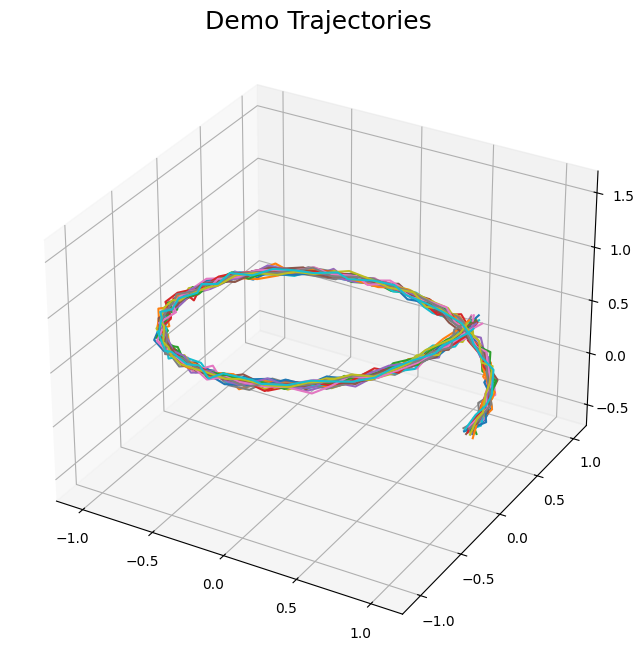

(<Figure size 1000x800 with 1 Axes>,
 <Axes3D: title={'center': 'Demo Trajectories'}>)

In [4]:
plot_trajectories(title="Demo Trajectories", trajectories=trajectories, show=True)

## 3. Transform into local reference frames

Transform trajectories into start and end reference frames.

In [5]:
from tpgmm.utils.geometry import transform_into_frames

translations = np.stack([
    np.stack([-traj[0], -traj[-1]]) for traj in trajectories
])
rotations = np.tile(np.eye(3), (num_demos, 2, 1, 1))

local_trajectories = transform_into_frames(trajectories, translations, rotations)
print(f"Local trajectories shape: {local_trajectories.shape}")

Local trajectories shape: (30, 2, 50, 3)


## 4. Add time dimension and prepare data

In [6]:
num_points = local_trajectories.shape[2]
time_vec = np.linspace(0, 1, num_points)[:, None]

local_with_time = []
for demo in local_trajectories:
    frames_with_time = []
    for frame in demo:
        frames_with_time.append(np.concatenate([frame, time_vec], axis=-1))
    local_with_time.append(np.array(frames_with_time))

local_with_time = np.array(local_with_time)

# Concatenate all demos
concat_data = np.concatenate(local_with_time, axis=1)
print(f"Concatenated data shape: {concat_data.shape}")

Concatenated data shape: (2, 1500, 4)


## 5. Fit TPGMM (NumPy backend)

Train the task-parameterized Gaussian mixture model using EM.

In [7]:
n_components = 8
tpgmm = TPGMM(n_components=n_components, verbose=True)
tpgmm.fit(concat_data)

print(f"\nWeights: {tpgmm.weights_}")
print(f"Means shape: {tpgmm.means_.shape}")
print(f"Covariances shape: {tpgmm.covariances_.shape}")

Started KMeans clustering


finished KMeans clustering
Start expectation maximization
Log likelihood: 11276.582034669485 improvement 27846.45907856423
Log likelihood: 14572.337913713383 improvement 3295.755879043898
Log likelihood: 14788.130058154175 improvement 215.79214444079116
Log likelihood: 14917.889663622345 improvement 129.75960546817078
Log likelihood: 15076.995728122176 improvement 159.1060644998306
Log likelihood: 15132.427750547058 improvement 55.432022424882234
Log likelihood: 15257.148224759268 improvement 124.72047421221032
Log likelihood: 15279.506944309931 improvement 22.3587195506625
Log likelihood: 15324.584757744607 improvement 45.0778134346765
Log likelihood: 15463.740170179963 improvement 139.15541243535517
Log likelihood: 15569.34595694939 improvement 105.60578676942714
Log likelihood: 15604.225215856774 improvement 34.8792589073837
Log likelihood: 15642.230603133627 improvement 38.00538727685307
Log likelihood: 15728.205317495194 improvement 85.97471436156775
Log likelihood: 15849.92940149

## 6. Visualize fitted GMM components

/home/robin/projects/TaskParameterizedGaussianMixtureModels/tpgmm/utils/plot/plot.py:99: RuntimeWarning: invalid value encountered in sqrt
  ellipsoid = np.dot(ellipsoid, np.sqrt(np.diag(eigenvalues))) @ eigenvectors.T


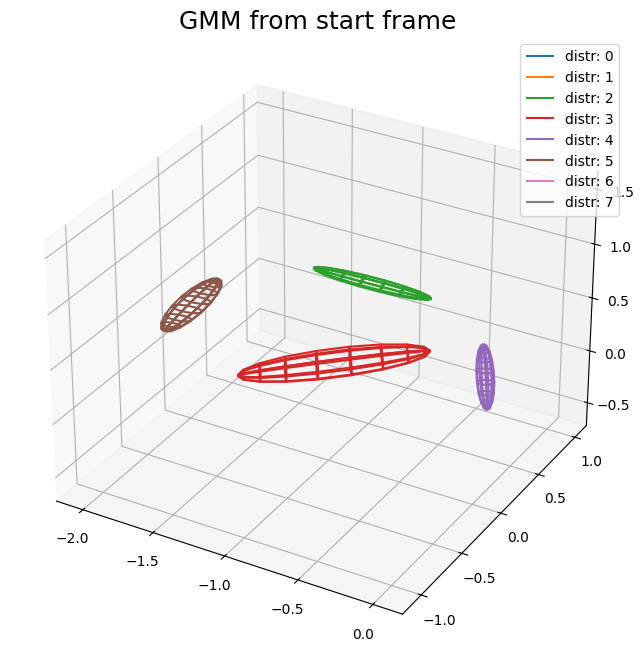

(<Figure size 1000x800 with 1 Axes>,
 <Axes3D: title={'center': 'GMM from start frame'}>)

In [8]:
frame_idx = 0
plot_ellipsoids(
    title="GMM from start frame",
    means=tpgmm.means_[frame_idx, :, :3],
    covs=tpgmm.covariances_[frame_idx, :, :3, :3],
    legend=True,
    show=True,
)

## 7. Model selection via BIC

100%|██████████| 12/12 [00:03<00:00,  3.33it/s]


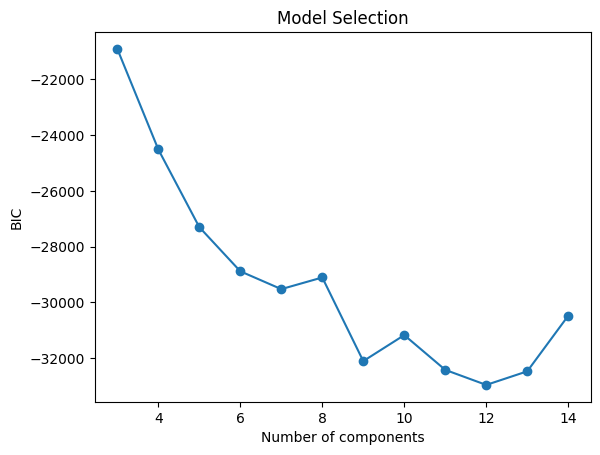

In [9]:
from tqdm import tqdm
import matplotlib.pyplot as plt

K = np.arange(3, 15)
bic_scores = []
for k in tqdm(K):
    model = TPGMM(n_components=k, reg_factor=1e-3)
    model.fit(concat_data)
    bic_scores.append(model.bic(concat_data))

fig, ax = plt.subplots()
ax.plot(K, bic_scores, marker="o")
ax.set_xlabel("Number of components")
ax.set_ylabel("BIC")
ax.set_title("Model Selection")
plt.show()

## 8. Gaussian Mixture Regression

Use the NumPy GMR to reconstruct a trajectory for new start/end positions.

In [21]:
gmr = GaussianMixtureRegression.from_tpgmm(tpgmm, input_idx=[3])

translation = np.array([trajectories[0][0], trajectories[0][-1]])
rotation_matrix = np.eye(3)[None].repeat(2, axis=0)
gmr.fit(translation=translation, rotation_matrix=rotation_matrix)

input_data = np.linspace(0, 1, 100)[:, None]
mu, cov = gmr.predict(input_data)
print(f"Predicted mean shape: {mu.shape}, covariance shape: {cov.shape}")

Predicted mean shape: (100, 3), covariance shape: (100, 3, 3)


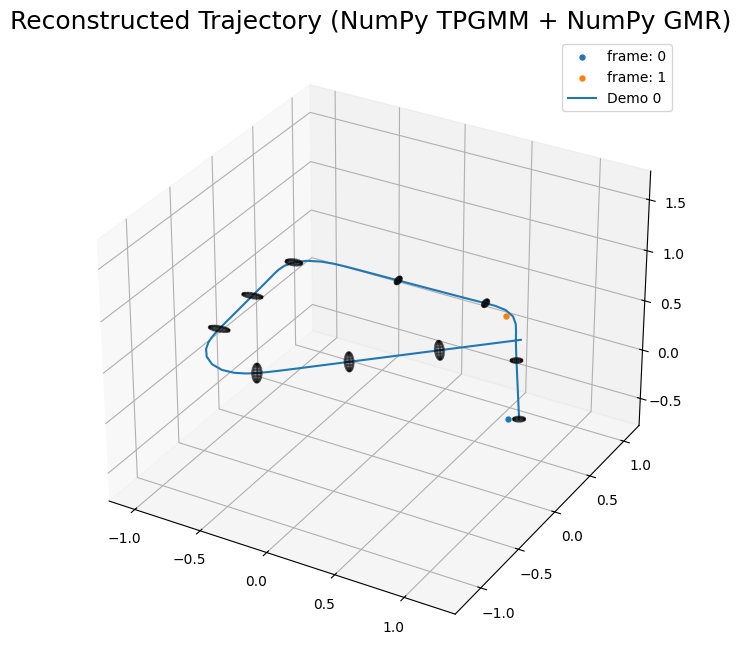

Distance to start: 0.0700
Distance to end: 0.3159


In [22]:
fig, ax = scatter(title="Reconstructed Trajectory (NumPy TPGMM + NumPy GMR)", data=translation[:, None])
fig, ax = plot_trajectories(trajectories=mu[None], fig=fig, ax=ax, legend=True)
plot_ellipsoids(means=mu[::10], covs=cov[::10], fig=fig, ax=ax, color="k", alpha=0.3, show=True)

print(f"Distance to start: {np.linalg.norm(translation[0] - mu[0]):.4f}")
print(f"Distance to end: {np.linalg.norm(translation[1] - mu[-1]):.4f}")